# Futures Rolling

## Introduction to Futures
Futures are a form of a contract drawn up between two parties to purchase or sell a quantity of an underlying asset at a specified date in the future. This date is known as the delivery or expiration. When this date is reached, the buyer must deliver the physical underlying (or cash equivalent) to the seller for the price agreed at the contract formation date.

In practice, futures are traded on exchanges for standardised quantities and qualities of the underlying. The prices are marked to market every day. Futures are incredibly liquid and are used heavily for speculative purposes. While futures were often utilised to hedge the prices of agricultural or industrial goods, a futures contract can be formed on any tangible or intangible underlying such as stock indices, interest rates of foreign exchange values.

The main difference between a futures contract and equity ownership is the fact that a futures contract has a limited window of availability by virtue of the expiration date. At any one instant, there will be a variety of futures contracts on the same underlying all with varying dates of expiry. The contract with the nearest date of expiry is known as the near contract.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from arbitragelab.util import (CrudeOilFutureRoller, NBPFutureRoller, RBFutureRoller)

In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Crude Oil WTI

NYMEX WTI Crude Oil futures (CL) is the world’s most liquid crude oil contract. When traders need the current oil price, they check the WTI Crude Oil price. WTI (West Texas Intermediate, a US light sweet crude oil blend) futures provide direct crude oil exposure and are the most efficient way to trade oil after a sharp rise in US crude oil production. They can also be used to hedge against adverse oil price moves or speculate on whether WTI oil prices will rise or fall.

https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_contract_specifications.html

### Termination of Trading

Trading terminates 3 business day prior to the 25th calendar day of the month prior to the contract month. If the 25th calendar day is not a business day, trading terminates 4 business days prior to the 25th calendar day of the month prior to the contract month.

In [4]:
# Load contract price data.
cl_df = pd.read_csv('./data/CL.csv')
cl_df['Dates'] = pd.to_datetime(cl_df['Dates'])
cl_df.dropna(inplace=True)
cl_df.index = cl_df['Dates']
cl_df = cl_df['2006-01': '2019-12']

In [5]:
# Fit corresponding roller and retrieve gaps.
wti_roller = CrudeOilFutureRoller().fit(cl_df)
wti_gaps = wti_roller.transform()

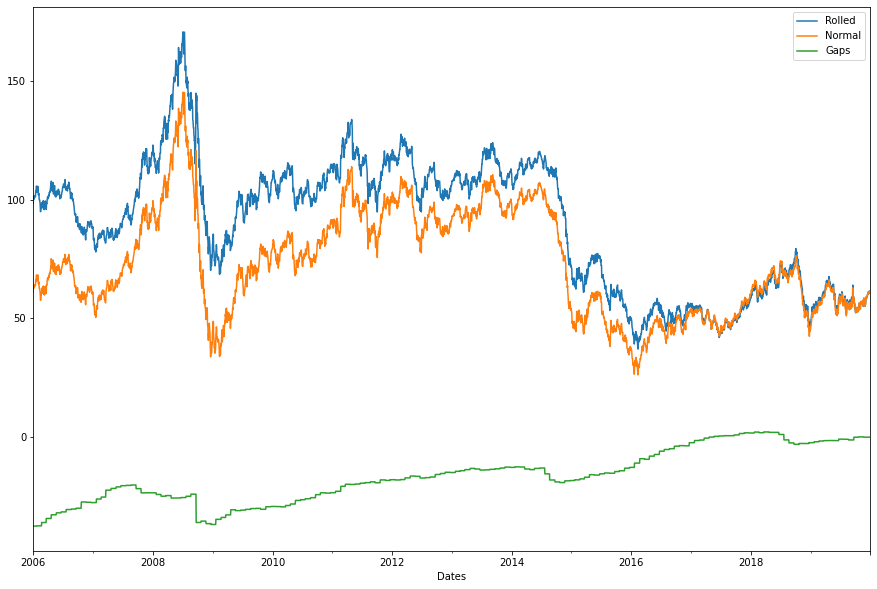

In [7]:
# Plot the Normal, Rolled and Gaps Series.
(cl_df['PX_LAST'] - wti_gaps).plot(figsize=(15,10))
cl_df['PX_LAST'].plot()
wti_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"]);

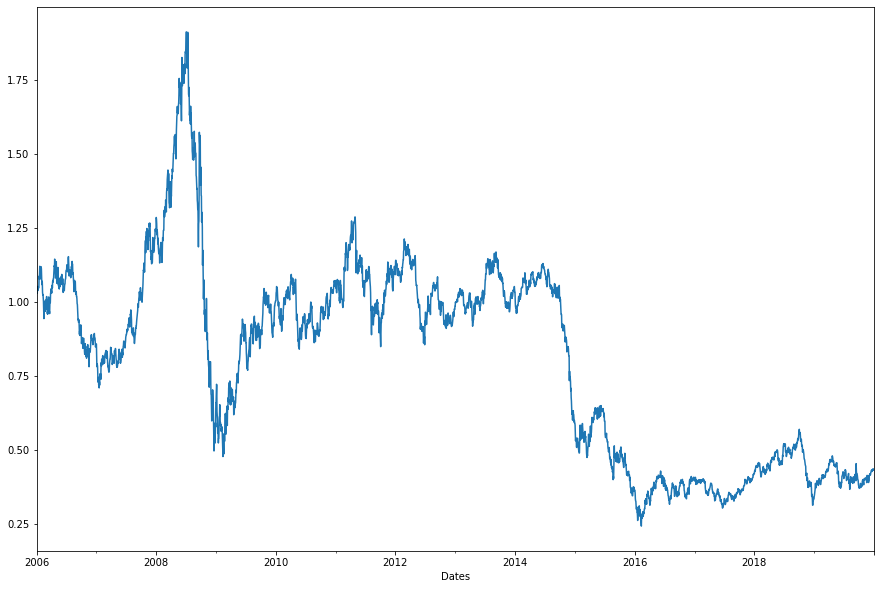

In [7]:
# Sometimes rolled contracts dip into negative territory. This
# can cause problems when used for ml models, thus there is the
# ability of using the parameter 'handle_negative_roll', which
# will process the price data into positive returns data.
non_negative_cl = wti_roller.transform(handle_negative_roll=True) 
non_negative_cl.to_csv('./data/NonNegative_CL_forward_roll.csv')
non_negative_cl.plot(figsize=(15,10));

In [8]:
# The diagnostic summary is a helper function to help the user
# easily double check expiration dates and their respective gap
# calculations.
wti_diag_frame = wti_roller.diagnostic_summary()
wti_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,1994-01-20,15.10,1994-01-21,15.27,0.17
1,1994-02-22,14.24,1994-02-23,14.30,0.06
2,1994-03-22,15.20,1994-03-23,15.35,0.15
3,1994-04-20,16.82,1994-04-21,16.46,-0.36
4,1994-05-20,18.92,1994-05-23,18.50,-0.42
5,1994-06-21,20.04,1994-06-22,20.65,0.61
6,1994-07-20,19.20,1994-07-21,19.42,0.22
7,1994-08-22,16.87,1994-08-23,17.58,0.71
8,1994-09-20,17.24,1994-09-21,17.31,0.07
9,1994-10-20,17.54,1994-10-21,17.41,-0.13


# NBP UK Natural Gas Futures

Natural gas is the third most important source of energy after oil and coal. The use of natural gas is growing quickly and is expected to overtake coal in the second spot by 2030.

The world’s largest producers of natural gas are currently the United States, Russia, Iran, Qatar, Canada, China and Norway. These countries have excess natural gas that can be exported to other countries around the world, which is either transported through pipelines or as liquefied natural gas (LNG).

In western Europe, gas is the dominant fuel for electricity production. Prices are set at several trading hubs around the region. The two most important hubs in the region are the National Balancing Point or NBP in the UK and the Title Transfer Facility or TTF in the Netherlands.

https://www.theice.com/products/910/UK-Natural-Gas-Futures

## Termination of Trading
Trading will cease at the close of business two Business Days prior to the first calendar day of the delivery month, quarter, season, or calendar.


In [10]:
# Load contract price data.
nbp_df = pd.read_csv('./data/NBP.csv')
nbp_df['Dates'] = pd.to_datetime(nbp_df['Dates'])
nbp_df.set_index('Dates', inplace=True)

In [12]:
# Fit corresponding roller and retrieve gaps.
nbp_roller = NBPFutureRoller().fit(nbp_df)
nbp_gaps = nbp_roller.transform()

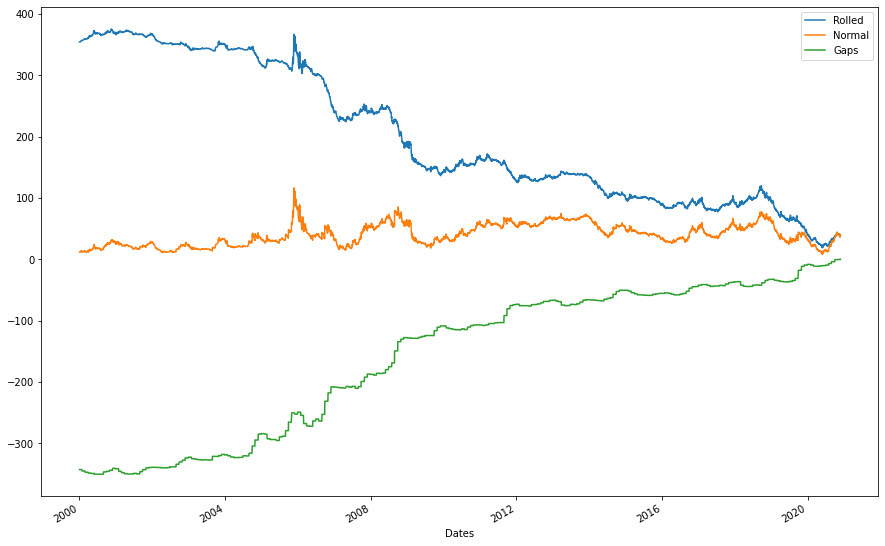

In [13]:
# Plot the Normal, Rolled and Gaps Series.
(nbp_df['PX_LAST'] - nbp_gaps).plot(figsize=(15,10))
nbp_df['PX_LAST'].plot()
nbp_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"]);

In [14]:
# The diagnostic summary is a helper function to help the user
# easily double check expiration dates and their respective gap
# calculations.
nbp_diag_frame = nbp_roller.diagnostic_summary()
nbp_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,2020-11-24,39.04,2020-11-25,39.48,0.44
1,2000-01-28,13.98,2000-01-31,11.55,-2.43
2,2000-02-28,13.90,2000-02-29,12.00,-1.90
3,2000-03-30,13.10,2000-03-31,11.75,-1.35
4,2000-04-27,14.83,2000-04-28,14.20,-0.63
5,2000-05-30,23.78,2000-05-31,22.60,-1.18
6,2000-06-29,18.18,2000-06-30,18.15,-0.03
7,2000-07-28,16.85,2000-07-31,16.90,0.05
8,2000-08-30,16.01,2000-08-31,19.65,3.64
9,2000-09-28,23.00,2000-09-29,23.95,0.95


# RBOB

RBOB products offer a way for investors to express views on crude oil, weather, consumer behavior and regulatory action in terms of current and future energy consumption. As the primary fuel for most automobiles on the road, gasoline is an integral commodity to the lives of most consumers. 

https://www.cmegroup.com/trading/energy/refined-products/rbob-gasoline_contract_specifications.html

### Termination of Trading
Trading terminates on the last business day of the month prior to the contract month.

In [9]:
# Load contract price data.
rb_df = pd.read_csv('./data/RB.csv').dropna()
rb_df['Dates'] = pd.to_datetime(rb_df['Dates'])
rb_df.set_index('Dates', inplace=True)
rb_df = rb_df['2006-01': '2019-12']

In [10]:
# Fit corresponding roller and retrieve gaps.
rbob_roller = RBFutureRoller().fit(rb_df)
rbob_gaps = rbob_roller.transform()

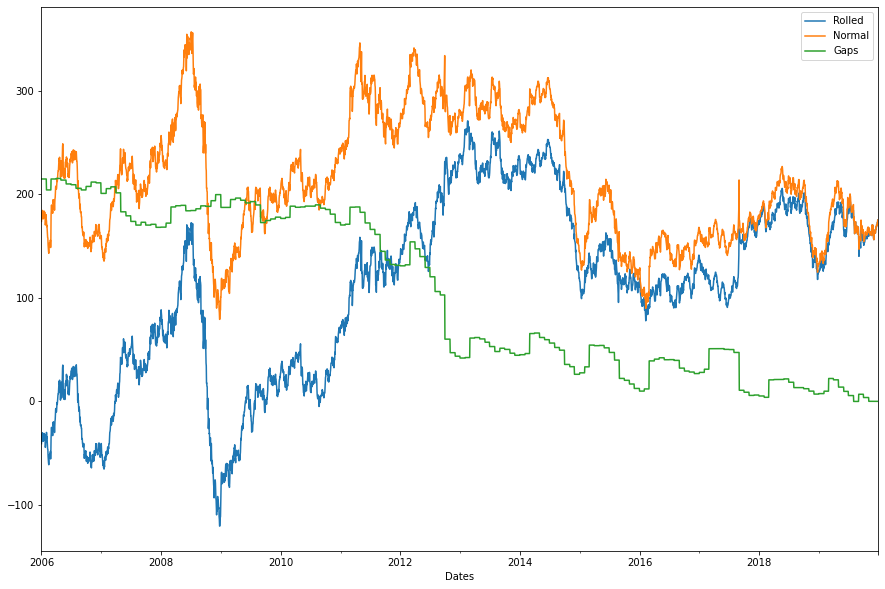

In [11]:
# Plot the Normal, Rolled and Gaps Series.
(rb_df['PX_LAST'] - rbob_gaps).plot(figsize=(15,10))
rb_df['PX_LAST'].plot()
rbob_gaps.plot()

plt.legend(["Rolled", "Normal", "Gaps"]);

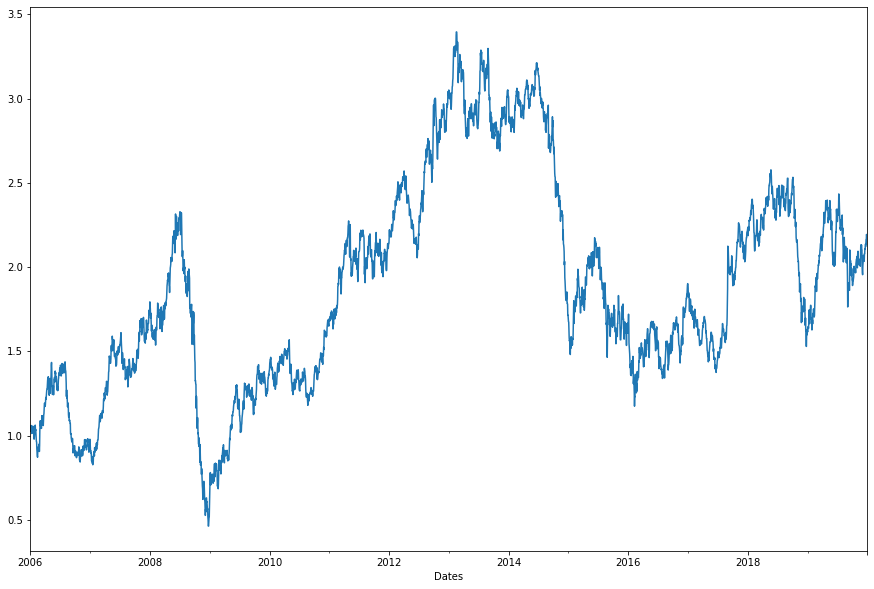

In [25]:
# In this case the rolled contract dips into negative territory.
# Thus the 'handle_negative_roll' parameter is used to post process
# the rolled future data.
non_negative_rbob = rbob_roller.transform(handle_negative_roll=True)
non_negative_rbob.to_csv('./data/NonNegative_RB_forward_roll.csv')
non_negative_rbob.plot(figsize=(15,10));

In [17]:
# The diagnostic summary is a helper function to help the user
# easily double check expiration dates and their respective gap
# calculations.
rb_diag_frame = rbob_roller.diagnostic_summary()
rb_diag_frame.head(10)

,last_on_termination_date,last_prices,open_day_after_termination_date,open_prices,gap
0,2005-12-30,174.00,2006-01-02,165.00,-9.00
1,2006-01-31,175.58,2006-02-01,165.00,-10.58
2,2006-02-28,154.43,2006-03-01,165.00,10.57
3,2006-03-31,206.45,2006-04-03,207.00,0.55
4,2006-04-28,221.00,2006-05-01,219.40,-1.60
5,2006-05-31,228.73,2006-06-01,225.00,-3.73
6,2006-06-30,239.31,2006-07-03,238.55,-0.76
7,2006-07-31,234.96,2006-08-01,231.50,-3.46
8,2006-08-31,182.07,2006-09-01,180.50,-1.57
9,2006-09-29,156.32,2006-10-02,159.70,3.38
